**<center>MINI-PROJET ENSEMBLE LEARNING</center>**
<center>DICHAMA KAMDEM Gabin Florent</center>
<center>GNEKOU FONTSING Séraphine Zita</center>
<center>FOKAM DJODOM Yannick</center>


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

2024-02-15 20:17:45.169538: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 20:17:45.574120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 20:17:45.574329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 20:17:45.637592: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 20:17:45.770190: I tensorflow/core/platform/cpu_feature_guar

# **A. Base des données**

In [ ]:
data = pd.read_excel('beer_quality.xlsx')
data

In [ ]:
data.info()

### **Analyse des variables predictives**

In [ ]:
X = data.drop('quality', axis=1)  
y = data['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.describe()

### **Analyse de la variable à predire y_train**

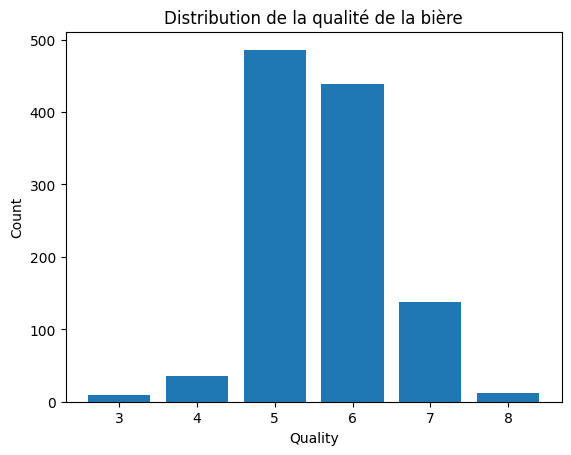

In [5]:
label_counts = y_train.value_counts()
plt.bar(label_counts.index, label_counts.values)

plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Distribution de la qualité de la bière')

plt.show()

**Commentaire:** La variable  « quality » et la majorité des autres variables présentent une distribution relativement centrée, comme on peut le voir par les moyennes proches des médianes (50e percentile). 

# **B. Classification binaire**

### **1) Créaation de la variable qualitative**

In [6]:
# Calcul de la médiane
median_y = np.median(y_train)

ybin_train = (y_train >= median_y).astype(int)
ybin_test = (y_test >= median_y).astype(int)
print(ybin_train.value_counts())
print(ybin_test.value_counts())

1    588
0    531
Name: quality, dtype: int64
1    267
0    213
Name: quality, dtype: int64


### **2) Optimisation d'un arbre de décision**

In [7]:
def model_analyser(best_model):
    #train
    start_time = time.time()
    best_model.fit(X_train, ybin_train)
    end_time = time.time()
    train_time = end_time - start_time
    #prediction
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    end_time = time.time()
    inference_time = end_time - start_time

    # Calcul des métriques de performance
    accuracy = accuracy_score(ybin_test, y_pred)
    precision = precision_score(ybin_test, y_pred)
    recall = recall_score(ybin_test, y_pred)
    f1 = f1_score(ybin_test, y_pred)

    print(f"best model: {best_model.get_params()}")
    #print(f"Précision : {precision}")
    #print(f"Rappel : {recall}")
    #print(f"Score F1 : {f1}")
    print(f"Accuracy : {accuracy}")
    print(f"Temps d'apprentissage : {round(train_time,3)} secondes")
    print(f"Temps d'inference : {round(inference_time,3)} secondes")

    # Matrice de confusion
    cm = confusion_matrix(ybin_test, y_pred)

    # Courbe ROC et AUC
    fpr, tpr, thresholds = roc_curve(ybin_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Création d'une figure avec 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4)) # 1 ligne, 2 colonnes

    # Affichage de la matrice de confusion
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax1)
    ax1.set_title("Matrice de confusion")
    ax1.set_xlabel('Classe prédite')
    ax1.set_ylabel('Vraie classe')

    # Affichage de la courbe ROC
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:0.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Taux de faux positifs')
    ax2.set_ylabel('Taux de vrais positifs')
    ax2.set_title('Courbe ROC')
    ax2.legend(loc="lower right")

    # Afficher la figure
    plt.tight_layout()
    plt.show()

best model: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 10, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Accuracy : 0.7333333333333333
Temps d'apprentissage : 0.003 secondes
Temps d'inference : 0.001 secondes


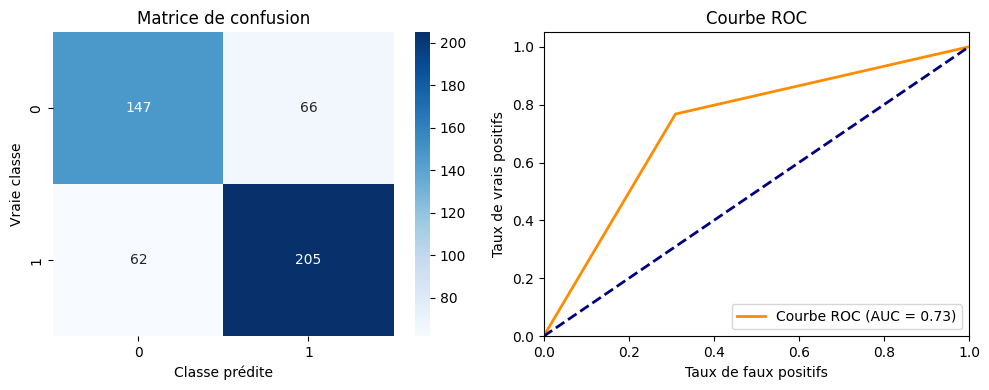

In [8]:
param_dist = {"max_depth": [5,6,7,8,9,10,15,20],
              "max_features": [int(f) for f in range(1,12,1)],
              "min_samples_split": [2, 3],
              "criterion": ["gini", "entropy"]
              }

tree = DecisionTreeClassifier()
random_search = RandomizedSearchCV(tree, param_distributions=param_dist, n_iter=10, cv=5)
random_search.fit(X_train, ybin_train)

best_model = random_search.best_estimator_
model_analyser(best_model)


### **3) Entraînement un ensemble d’arbres de décision « faibles »**

<Figure size 1200x800 with 0 Axes>

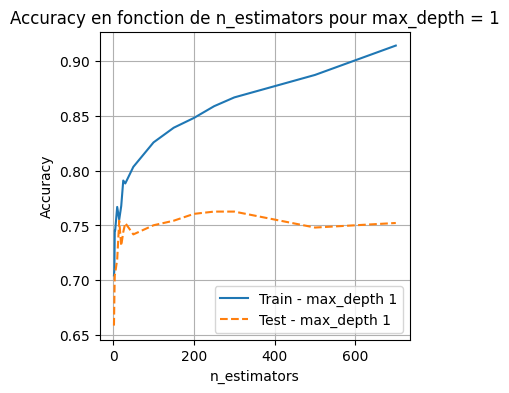

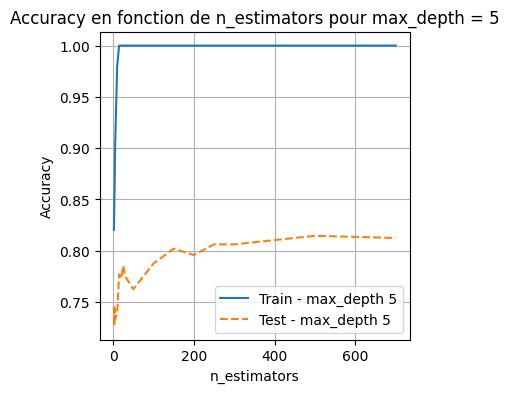

In [9]:
n_estimators_list = [2,3,4,5, 10, 15, 20, 25,30, 50, 100, 150, 200, 250, 300,500, 700]
max_depth_list = [1,5]
execution_times = []

plt.figure(figsize=(12, 8))

for max_depth in max_depth_list:
    train_accuracies = []
    test_accuracies = []
    start_time = time.time()
    for n_estimators in n_estimators_list:
        # Création et entraînement du modèle AdaBoost
        ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth), 
                                     n_estimators=n_estimators,
                                     random_state=42)
        
        ada_clf.fit(X_train, ybin_train)

        # Calcul de l'accuracy sur l'ensemble d'apprentissage
        y_pred_train = ada_clf.predict(X_train)
        train_accuracies.append(accuracy_score(ybin_train, y_pred_train))

        # Calcul de l'accuracy sur l'ensemble de test
        y_pred_test = ada_clf.predict(X_test)
        test_accuracies.append(accuracy_score(ybin_test, y_pred_test))
    end_time = time.time()
    execution_times.append(end_time - start_time)

    # Tracer la courbe pour ce max_depth
    plt.figure(figsize=(4, 4))
    plt.plot(n_estimators_list, train_accuracies, label=f'Train - max_depth {max_depth}')
    plt.plot(n_estimators_list, test_accuracies, label=f'Test - max_depth {max_depth}', linestyle='--')
    plt.xlabel('n_estimators')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy en fonction de n_estimators pour max_depth = {max_depth}')
    plt.legend()
    plt.grid()
    plt.show()



best model: {'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': 5, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__random_state': None, 'estimator__splitter': 'best', 'estimator': DecisionTreeClassifier(max_depth=5), 'learning_rate': 1.0, 'n_estimators': 500, 'random_state': 42}
Accuracy : 0.8145833333333333
Temps d'apprentissage : 1.445 secondes
Temps d'inference : 0.045 secondes


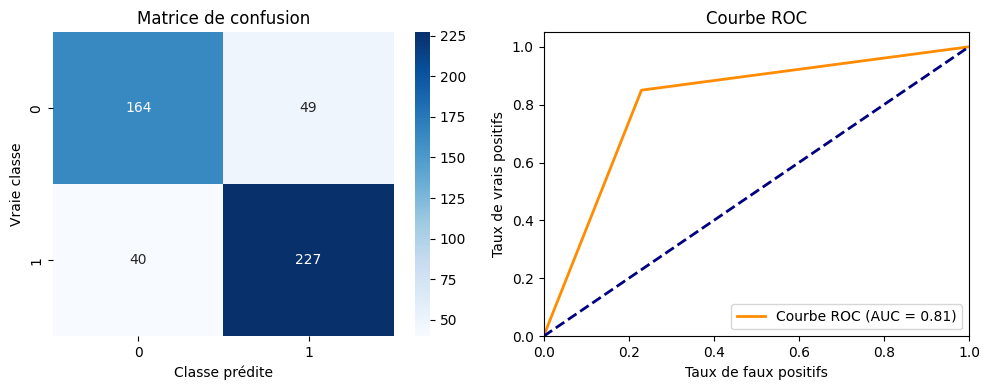

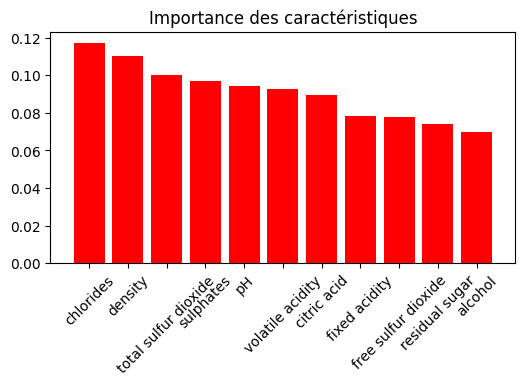

In [10]:
best_ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth= 5), 
                                     n_estimators=500,
                                     random_state=42)

best_ada_clf.fit(X_train, ybin_train)
feature_importances = best_ada_clf.feature_importances_

indices = feature_importances.argsort()[::-1]
model_analyser(best_ada_clf)

plt.figure(figsize=(6, 3))
plt.title("Importance des caractéristiques")
plt.bar(range(X_train.shape[1]), feature_importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=45)
plt.xlim([-1, X_train.shape[1]])
plt.show()

#### **Commentaires**

- le meilleur modèle est l'ensemble 500 d'arbres de decision de max_deepth = 5.

- oui, il est possible de mesurer l'importance d'une caractéristique dans la décision. 
AdaBoost ajuste les poids des observations à chaque itération, donnant plus d'importance aux cas difficiles. 
L'importance des caractéristiques est calculée en fonction de la contribution de chaque caractéristique à 
améliorer la précision des arbres de décision faibles au sein de l'ensemble.

- - **Biais** : AdaBoost reduit le biais en se concentrant de manière itérative sur les exemples les plus difficiles à classifier. Cependant, dans le cas des modèles faibles eux-mêmes très biaisés (arbre avec max_depth très petit), AdaBoost ne pas réussi à produire un modèle final avec un biais plus faible que celui obtenue avec un arbre decision optimal obtenu par recherche aleatoire. 

- - **Variance** : l'impact de AdaBoost sur la variance du modèle final est peut present, car si les estimateurs sont trop complexes (profonds), le modèle AdaBoost surajuste les données d'entraînement, conduisant à une variance élevée.

## **C. Classification multiple**

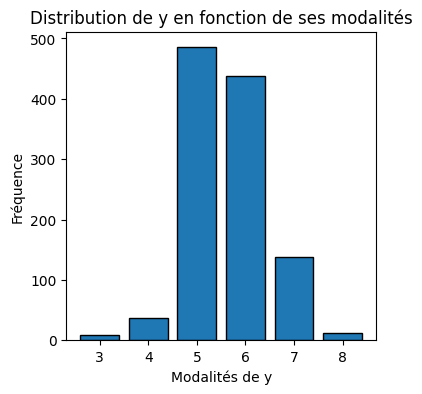

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

# Compter les occurrences de chaque modalité dans y_train
y_train_counts = Counter(y_train)

# Préparer les données pour le diagramme en bâtons
modalites = list(y_train_counts.keys())
frequences = list(y_train_counts.values())

# Créer le diagramme en bâtons
plt.figure(figsize=(4, 4))
plt.bar(modalites, frequences, edgecolor='black', align='center')
plt.xlabel('Modalités de y')
plt.ylabel('Fréquence')
plt.title('Distribution de y en fonction de ses modalités')
plt.xticks(range(min(y_train), max(y_train) + 1))  # Pour afficher toutes les modalités sur l'axe des x
plt.show()


1) Création de la nouvelle variable quantitative.

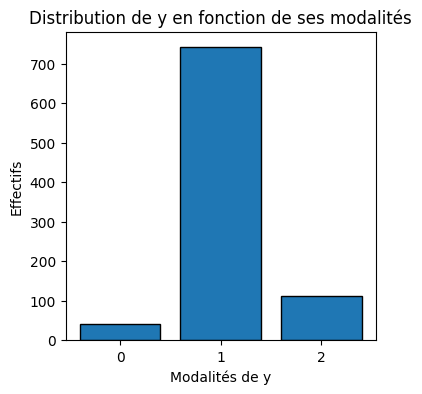

In [66]:
ymulti_train = y_train.apply(lambda value: 0 if value < 5 else 1 if 5 <=  value < 7 else 2 )
ymulti_test = y_test.apply(lambda value: 0 if value < 5 else 1 if 5 <=  value < 7 else 2 )

X_train, X_val, ymulti_train, ymulti_val = train_test_split(X_train, ymulti_train, test_size=0.20, random_state=42)

y_train_counts = ymulti_train.value_counts()

plt.figure(figsize=(4, 4))
plt.bar(y_train_counts.index, y_train_counts, edgecolor='black', align='center')
plt.xlabel('Modalités de y')
plt.ylabel('Effectifs')
plt.title('Distribution de y en fonction de ses modalités')
plt.xticks(range(min(ymulti_train), max(ymulti_train) + 1))  
plt.show()


**Commentaire**: Avec une categorisation de note: basse([0;5[), moyenne([5;7[) et elevée([7;10]), il est clair que les classes de qualité basse et elevée sont sous-représentées par rapport à la classe moyenne. Cette disproportion pourrait conduire à un biais dans le modèle de classification en faveur de la classe Moyenne plus représentées. Pour remédier à cela, nous pouvons envisager d'équilibrer les classes en utilisant l'augmentation des données pour les classes minoritaires (par exemple, en utilisant SMOTE).

Equilibrage: augmentation de données (SMOTE)

In [13]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Création de l'objet SMOTE
smote = SMOTE()

# Appliquer SMOTE à X_train et y_train
X_train_smote, ymulti_train_smote = smote.fit_resample(X_train, ymulti_train)

# Vérifier les nouveaux effectifs
print("Effectifs après SMOTE :", Counter(ymulti_train_smote))


Effectifs après SMOTE : Counter({1: 743, 2: 743, 0: 743})


### **Partie 1:**

#### **Modèle sans equilibrage des données**

In [ ]:
y_train_cat = to_categorical(ymulti_train, num_classes=3)
y_test_cat = to_categorical(ymulti_test, num_classes=3)
y_val_cat = to_categorical(ymulti_val, num_classes=3)

# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

neurons= [8, 16, 32, 64, 128]
for n in neurons:
    print (f'modele avec {n} nombre de neuronnes')
    model = Sequential([
        InputLayer(input_shape=(X_train_scaled.shape[1],)),
        Dense(64, activation='relu'),  
        Dense(3, activation='softmax')  
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',  
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # Entraînement du modèle 
    
    start_time = time.time()
    history = model.fit(
        X_train_scaled, y_train_cat,
        validation_data=(X_val_scaled, y_val_cat),
        epochs=100,
        callbacks=[early_stopping],
        verbose=0
    )
    end_time = time.time()
    train_time = end_time - start_time

    start_time = time.time()
    y_pred = model.predict(X_test_scaled)
    end_time = time.time()
    inference_time = end_time - start_time

    y_pred = np.argmax(y_pred, axis=1)
    eval_result= model.evaluate(X_test_scaled, y_test_cat)
    train_eval_result= model.evaluate(X_train_scaled, y_train_cat)
    print("\nTrain Loss :", train_eval_result[0], "Train Accuracy :", train_eval_result[1])
    print("Test Loss :", eval_result[0], "Test Accuracy :", eval_result[1])
    print(f"Temps d'apprentissage : {round(train_time,3)} secondes")
    print(f"Temps d'inference : {round(inference_time,3)} secondes")

    # Matrice de confusion
    cm = confusion_matrix(ymulti_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.title(f'Matrice de Confusion pour modèle avec {n} neuronnes')
    plt.show()


#### **Modèle avec equilibrage de données**

modele avec 8 nombre de neuronnes
70/70 [==============================] - 0s 1ms/step - loss: 0.3093 - accuracy: 0.8937

Train Loss : 0.3092838525772095 Train Accuracy : 0.8936743140220642
Test Loss : 0.6282708644866943 Test Accuracy : 0.7416666746139526
Temps d'apprentissage : 3.518 secondes
Temps d'inference : 0.059 secondes


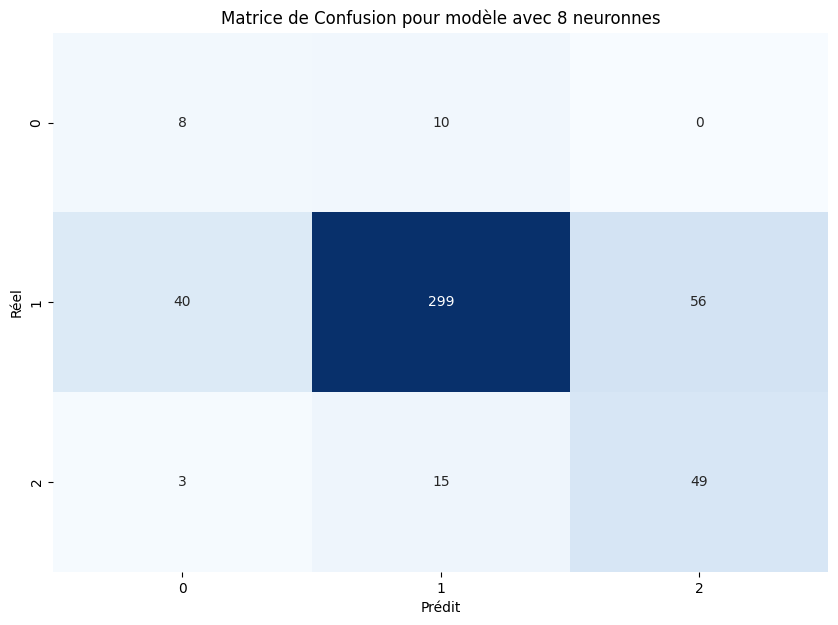

modele avec 16 nombre de neuronnes
70/70 [==============================] - 0s 1ms/step - loss: 0.3675 - accuracy: 0.8681

Train Loss : 0.3675353229045868 Train Accuracy : 0.8681023120880127
Test Loss : 0.6378581523895264 Test Accuracy : 0.737500011920929
Temps d'apprentissage : 2.591 secondes
Temps d'inference : 0.07 secondes


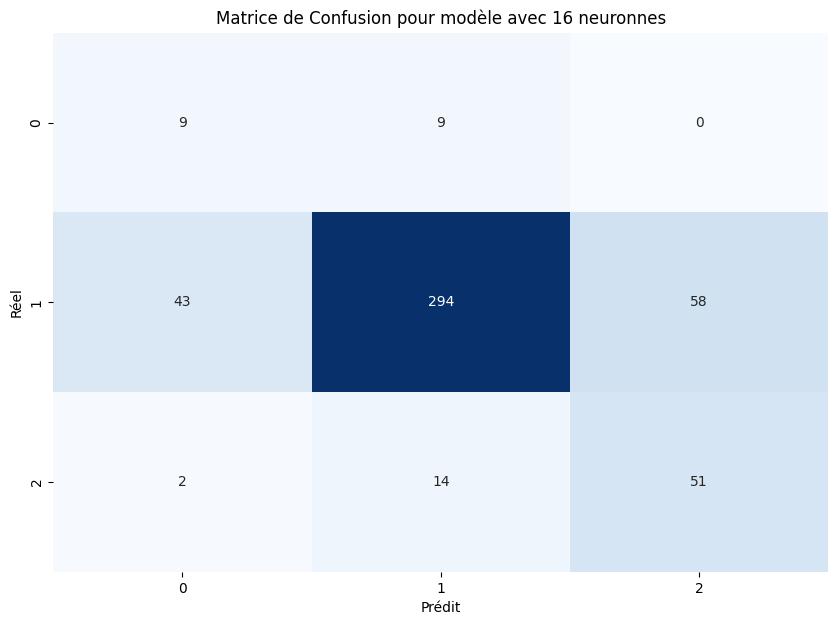

modele avec 32 nombre de neuronnes
70/70 [==============================] - 0s 898us/step - loss: 0.4531 - accuracy: 0.8219

Train Loss : 0.45305559039115906 Train Accuracy : 0.8218932151794434
Test Loss : 0.6593068838119507 Test Accuracy : 0.71875
Temps d'apprentissage : 1.924 secondes
Temps d'inference : 0.05 secondes


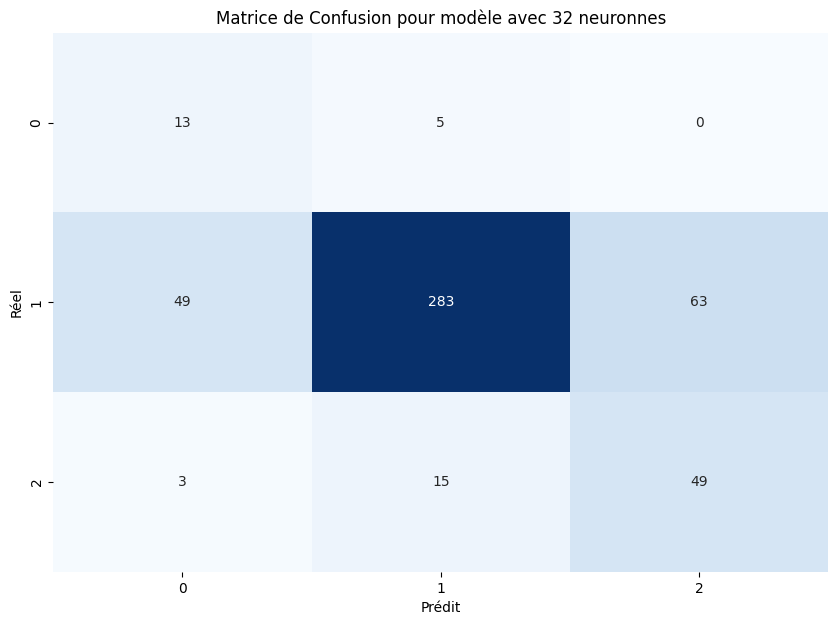

modele avec 64 nombre de neuronnes
70/70 [==============================] - 0s 1ms/step - loss: 0.3384 - accuracy: 0.8757

Train Loss : 0.3384494483470917 Train Accuracy : 0.8757290244102478
Test Loss : 0.6219530701637268 Test Accuracy : 0.7229166626930237
Temps d'apprentissage : 3.078 secondes
Temps d'inference : 0.05 secondes


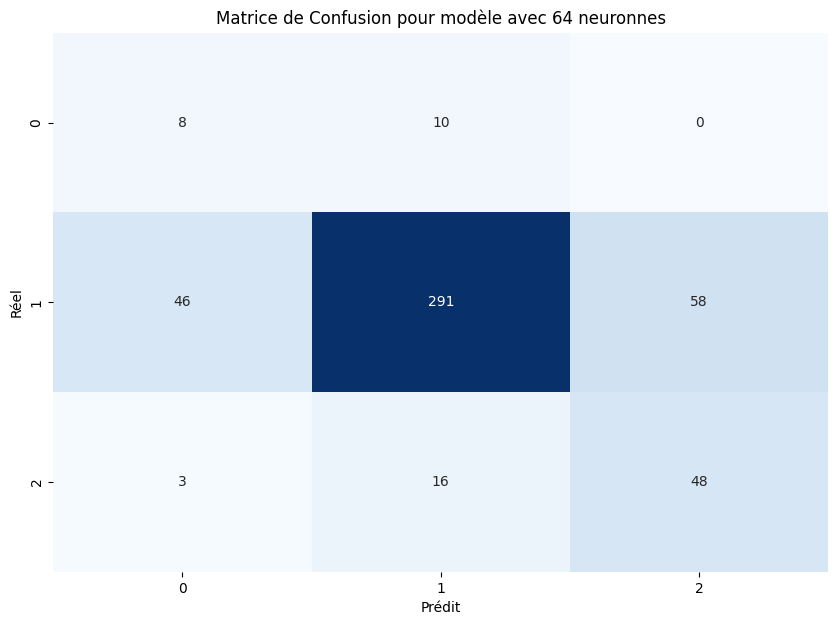

modele avec 128 nombre de neuronnes
70/70 [==============================] - 0s 602us/step - loss: 0.3684 - accuracy: 0.8650

Train Loss : 0.3683824837207794 Train Accuracy : 0.8649618625640869
Test Loss : 0.6304103136062622 Test Accuracy : 0.7354166507720947
Temps d'apprentissage : 2.794 secondes
Temps d'inference : 0.065 secondes


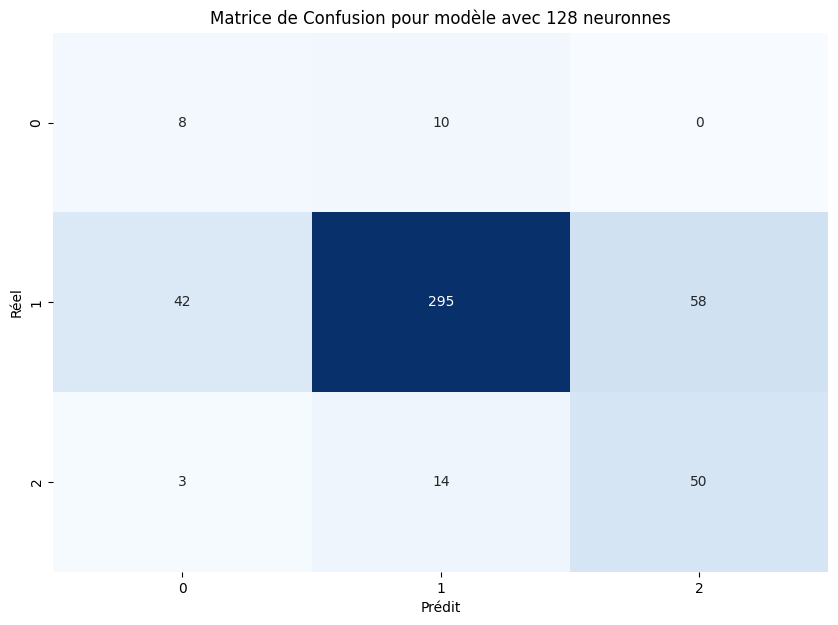

In [18]:
y_train_cat = to_categorical(ymulti_train_smote, num_classes=3)
y_test_cat = to_categorical(ymulti_test, num_classes=3)
y_val_cat = to_categorical(ymulti_val, num_classes=3)

# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

neurons= [8, 16, 32, 64, 128]
for n in neurons:
    print (f'modele avec {n} nombre de neuronnes')
    model = Sequential([
        InputLayer(input_shape=(X_train_scaled.shape[1],)),
        Dense(64, activation='relu'),  
        Dense(3, activation='softmax')  
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',  
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    # Entraînement du modèle 
    
    start_time = time.time()
    history = model.fit(
        X_train_scaled, y_train_cat,
        validation_data=(X_val_scaled, y_val_cat),
        epochs=100,
        callbacks=[early_stopping],
        verbose=0
    )
    end_time = time.time()
    train_time = end_time - start_time

    start_time = time.time()
    y_pred = model.predict(X_test_scaled)
    end_time = time.time()
    inference_time = end_time - start_time

    y_pred = np.argmax(y_pred, axis=1)
    eval_result= model.evaluate(X_test_scaled, y_test_cat)
    train_eval_result= model.evaluate(X_train_scaled, y_train_cat)
    print("\nTrain Loss :", train_eval_result[0], "Train Accuracy :", train_eval_result[1])
    print("Test Loss :", eval_result[0], "Test Accuracy :", eval_result[1])
    print(f"Temps d'apprentissage : {round(train_time,3)} secondes")
    print(f"Temps d'inference : {round(inference_time,3)} secondes")

    # Matrice de confusion
    cm = confusion_matrix(ymulti_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.title(f'Matrice de Confusion pour modèle avec {n} neuronnes')
    plt.show()


**Conclusion:** Pour le meilleur modèle sans équilibrage, comme on l’avait prédit le modèle à un fort biais pour les classes minoritaires mais grâce à une surreprésentation de la classe 1 ( qualité moyenne), l’accuracy du modèle est élevée. l’augmentation de données à permis de réduire le biais mais à côté a augmenté le temps d’apprentissage et réduit  la performance de globale du modèle. Cette méthode d'équilibrage ne semble pas adaptée à la situation.

#### **Faire un bagging**

15/15 [==============================] - 0s 641us/step
Modèle avec 2 estimateurs
	Accuracy du modèle Bagging en apprentissage: 0.879888266324997
	Accuracy du modèle Bagging en validation: 0.8208333333333333
	Temps d'apprentissage : 5.67 secondes
	Temps d'inference : 0.117 secondes
15/15 [==============================] - 0s 592us/step
Modèle avec 3 estimateurs
	Accuracy du modèle Bagging en apprentissage: 0.8763501048088074
	Accuracy du modèle Bagging en validation: 0.8291666666666667
	Temps d'apprentissage : 7.979 secondes
	Temps d'inference : 0.175 secondes
15/15 [==============================] - 0s 573us/step
Modèle avec 5 estimateurs
	Accuracy du modèle Bagging en apprentissage: 0.8800000071525573
	Accuracy du modèle Bagging en validation: 0.8416666666666667
	Temps d'apprentissage : 14.096 secondes
	Temps d'inference : 0.264 secondes
15/15 [==============================] - 0s 658us/step
Modèle avec 10 estimateurs
	Accuracy du modèle Bagging en apprentissage: 0.8754189908504486
	A

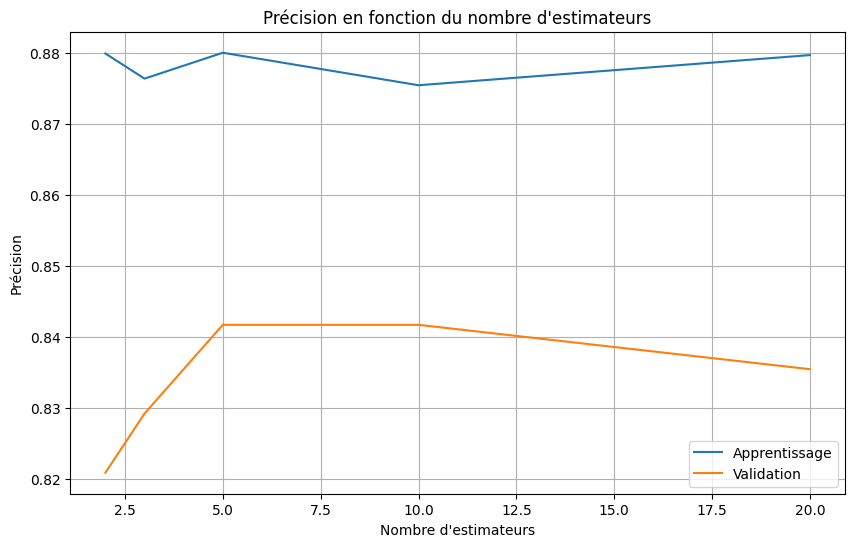

In [26]:
from sklearn.utils import resample
import numpy as np

# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

def create_model():
    model = Sequential([
        InputLayer(input_shape=(X_train_scaled.shape[1],)),
        Dense(32, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

n_estimators_range = [2,3,5,10,20] 
train_accuracies = []
val_accuracies = []

for n_estimators in n_estimators_range : 
    models = []  
    predictions = [] 
    trains_time = [] 
    inferences_time = []

    for i in range(n_estimators):
        X_train_i, y_train_i = resample(X_train_scaled, y_train_cat)

        start_time = time.time()
        model_i = create_model()
        model_i.fit(X_train_i, y_train_i, epochs=100, verbose=0)
        end_time = time.time()
        train_time = end_time - start_time
        trains_time.append(train_time)
        models.append(model_i)

        start_time = time.time()
        y_pred_i = model_i.predict(X_test_scaled)
        end_time = time.time()
        inference_time = end_time - start_time
        inferences_time.append(inference_time)
        predictions.append(y_pred_i)

    # Agréger les prédictions
    avg_val_predictions = np.mean(predictions, axis=0)
    final_val_predictions = np.argmax(avg_val_predictions, axis=1)

    # Calculer la précision pour l'ensemble de validation
    val_accuracy = accuracy_score(ymulti_test, final_val_predictions)
    val_accuracies.append(val_accuracy)

    # Calculer la précision moyenne pour l'ensemble d'apprentissage
    train_accuracy = np.mean([model.evaluate(X_train_scaled, y_train_cat, verbose=0)[1] for model in models])
    train_accuracies.append(train_accuracy)
    train_time = np.sum(trains_time)
    inference_time = np.sum(inferences_time)
    print(f'Modèle avec {n_estimators} estimateurs')
    print(f'\tAccuracy du modèle Bagging en apprentissage: {train_accuracy}')
    print(f'\tAccuracy du modèle Bagging en validation: {val_accuracy}')
    print(f"\tTemps d'apprentissage : {round(train_time,3)} secondes")
    print(f"\tTemps d'inference : {round(inference_time,3)} secondes")
    

# Tracer la courbe de précision en fonction du nombre d'estimateurs
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_accuracies, label='Apprentissage')
plt.plot(n_estimators_range, val_accuracies, label='Validation')
plt.xlabel('Nombre d\'estimateurs')
plt.ylabel('Précision')
plt.title('Précision en fonction du nombre d\'estimateurs')
plt.legend()
plt.grid()
plt.show()



**Commentaire:** Le modèle avec 5 estimateurs présente un bon compromis avec une accuracy en apprentissage et en validation et un temps d'apprentissage raisonnable.

**Conclusion:**  L'analyse des résultats du bagging indique un équilibre entre le biais et la variance. En augmentant le nombre d'estimateurs, l'accuracy en apprentissage reste relativement stable, tandis que l'accuracy en validation atteint un plateau. Cela suggère que l'ajout d'estimateurs supplémentaires ne conduit pas à un sur apprentissage significatif, mais n'améliore pas non plus de manière significative la capacité du modèle à généraliser (diminution marginale du biais).

### **Partie 2**

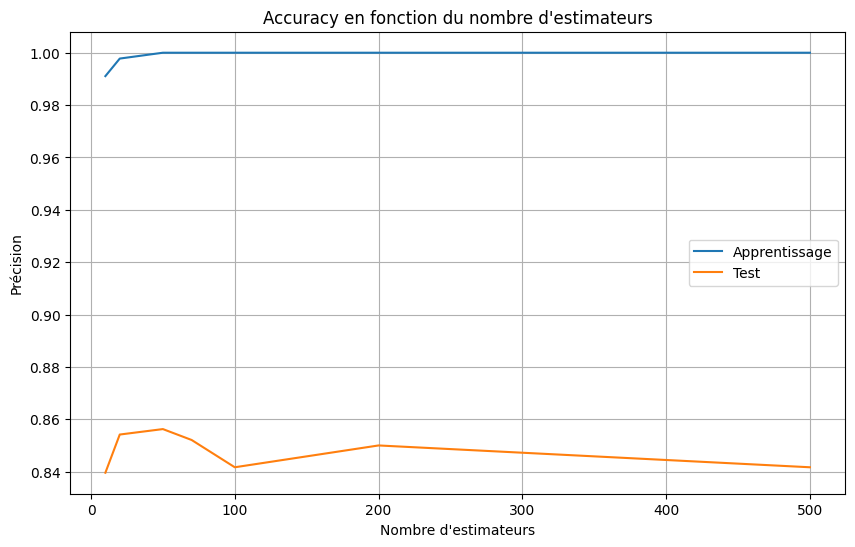

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train_accuracies = []
test_accuracies = []
n_estimators_options = [10, 20,50, 70, 100, 200, 500]  


for n_estimators in n_estimators_options:
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=None, random_state=42)
    rf.fit(X_train_scaled, ymulti_train)
    
    y_train_pred = rf.predict(X_train_scaled)
    y_test_pred = rf.predict(X_test_scaled)
    
    train_accuracies.append(accuracy_score(ymulti_train, y_train_pred))
    test_accuracies.append(accuracy_score(ymulti_test, y_test_pred))

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_options, train_accuracies, label='Apprentissage')
plt.plot(n_estimators_options, test_accuracies, label='Test')
plt.xlabel('Nombre d\'estimateurs')
plt.ylabel('Précision')
plt.title('Accuracy en fonction du nombre d\'estimateurs')
plt.legend()
plt.grid()
plt.show()


#### **Optimiser les Paramètres max_depth et n_estimators avec une Recherche Aléatoire**

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best model:  {'n_estimators': 200, 'max_depth': None}
Train Accuracy:  1.0
Test Accuracy:  0.7520833333333333
Temps d'apprentissage: 0.7221596240997314 secondes
Temps d'inférence: 0.01190328598022461 secondes
[[  3  15   0]
 [ 35 306  54]
 [  2  13  52]]


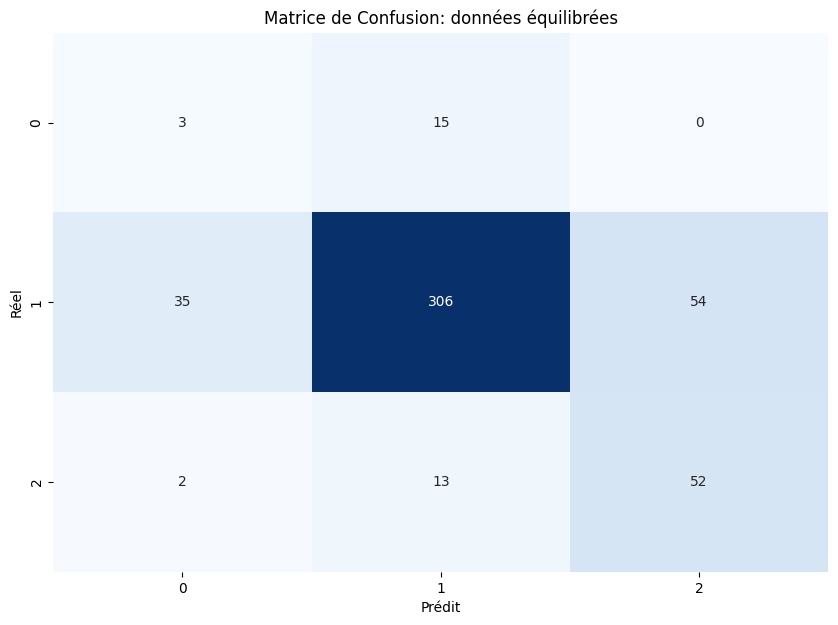

In [71]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

#données equilibées
X_train_scaled = scaler.fit_transform(X_train_smote)
ymulti_train = ymulti_train_smote

#données non equilibées
#X_train_scaled = scaler.fit_transform(X_train)


param_dist = {
    "max_depth": [3, None] + list(np.arange(5, 51, 5)),  
    "n_estimators": [10, 20,50, 70, 100, 200, 500]   # Nombre d'estimateurs
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train_scaled, ymulti_train)


# Évaluer le modèle avec les meilleurs paramètres
best_model = random_search.best_estimator_

start_time = time.time()
best_model.fit(X_train_scaled, ymulti_train)
end_time = time.time()
train_time = end_time - start_time


start_time = time.time()
y_test_pred = best_model.predict(X_test_scaled)
end_time = time.time()
y_train_pred = best_model.predict(X_train_scaled)

print("Best model: ", random_search.best_params_)
print("Train Accuracy: ", accuracy_score(ymulti_train, y_train_pred))
print("Test Accuracy: ", accuracy_score(ymulti_test, y_test_pred))
print(f"Temps d'apprentissage: {train_time} secondes")
print(f"Temps d'inférence: {end_time - start_time} secondes")

# Matrice de confusion
cm = confusion_matrix(ymulti_test, y_test_pred)
print(cm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title(f'Matrice de Confusion: données équilibrées')
plt.show()



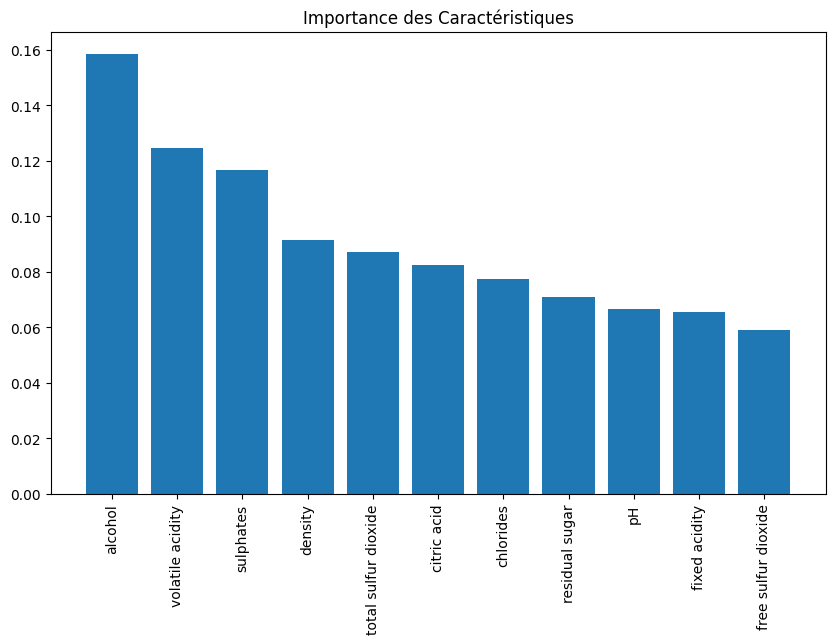

In [69]:
feature_importances = best_model.feature_importances_
features = X_train.columns
importances = pd.DataFrame({'feature': features, 'importance': feature_importances})
importances = importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.title('Importance des Caractéristiques')
plt.bar(range(len(importances)), importances['importance'])
plt.xticks(range(len(importances)), importances['feature'], rotation=90)
plt.show()
